In [1]:
using Knet#: Knet, minibatch, param, param0, softmax, nll, bmm, relu, dropout, progress!, adam
using CUDA: CuArray
using Pickle
using NPZ
using Statistics: mean, std
using StatsBase: sample, Weights
using DataStructures: OrderedDict
using LinearAlgebra
using OMEinsum
using Plots

┌ Info: OMEinsum loaded the CUDA module successfully
└ @ OMEinsum C:\Users\HP\.julia\packages\OMEinsum\7KrWH\src\cueinsum.jl:98


# Model

### Base Layers 

In [2]:
struct Linear; W; b; end
Linear(i::Int, o...) =
    Linear(param(o..., i, atype=ATYPE), param0(o..., atype=ATYPE))
(l::Linear)(x) =
    reshape(reshape(l.W,:,size(l.W)[end]) * reshape(x,size(x)[1],:), size(l.W)[1:end-1]..., size(x)[2:end]...) .+ l.b

struct Activation; f; o; end
Activation(f, o...) = 
    Activation(f, o)
(a::Activation)(x) =
    a.f.(x, a.o...)

struct Embedding; W; end
Embedding(n_ttypes::Int, embed::Int) =
    Embedding(param(embed, n_ttypes, atype=ATYPE))
(e::Embedding)(x) = 
    e.W[:, x] * √size(e.W, 1)

struct Dropout; p; end
(d::Dropout)(x) =
    dropout(x, d.p)

struct LayerNorm; W; b; ϵ; end
LayerNorm(d_model; eps=1e-6) = 
    LayerNorm(param(d_model; init=ones, atype=ATYPE),
              param(d_model, init=zeros, atype=ATYPE),
              eps)
function (ln::LayerNorm)(x, o...; dims=1)
    μ = mean(x, dims=dims)
    σ = std(x, mean=μ, dims=dims, corrected=false)
    ln.W .* (x .- μ) ./ (σ .+ eltype(x)(ln.ϵ)) .+ ln.b
end

struct PositionalEncoding; W; dropout; end
function PositionalEncoding(d_model::Int; dropout=0.1, max_len=20000)
    W = zeros(d_model, max_len)
    pos = exp.((0:2:d_model-1) .* (-log(10000)/d_model)) * (0:max_len-1)'
    W[1:2:end, :] = sin.(pos)
    W[2:2:end, :] = cos.(pos)
    PositionalEncoding(ATYPE(W), Dropout(dropout))
end
function (pe::PositionalEncoding)(x)
    pe.dropout(x .+ pe.W[:, 1:size(x,2), :])
end

struct Chain; layers; end
Chain(l, l_...) =
    Chain(append!(Vector{Any}([l]), l_))
function (c::Chain)(x, o...; state=nothing)
    training = state == nothing
    for layer in c.layers
        if (typeof(layer) != TransformerEncoder) || training
            x = layer(x, o...)
        else
            x, state = layer(x, o..., state=state)
        end
    end
    training ? x : (x, state)
end


### Attention

In [3]:
# https://arxiv.org/pdf/2006.16236.pdf
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/attention/attention_layer.py
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/recurrent/attention/self_attention/attention_layer.py
struct Attention; q; k; v; o; inner; masker; end
Attention(d_model::Int, n_heads::Int, inner, masker) =
    Attention(Linear(d_model, d_model÷n_heads, n_heads),
              Linear(d_model, d_model÷n_heads, n_heads),
              Linear(d_model, d_model÷n_heads, n_heads),
              Linear(d_model, d_model),
              inner, masker)
function (a::Attention)(q, k, v; state=nothing)
    training = state==nothing
    if training
        _, T, B = size(q); H = size(a.q.W, 2)

        q = reshape(a.q(q), (T, :, H, B))
        k = reshape(a.k(k), (T, :, H, B))
        v = reshape(a.v(v), (T, :, H, B))

        o = a.inner(q, k, v, mask=a.masker(T))
        return a.o(reshape(o, (:, T, B)))
    else
        _, _, B = size(q); H = size(a.q.W, 2)

        q = reshape(a.q(q), (B, H, :))
        k = reshape(a.k(k), (B, H, :))
        v = reshape(a.v(v), (B, H, :))
    
        v_, state = a.inner(q, k, v, state=state)
        o = a.o(reshape(v_, (:, B)))
        return o, state
    end
end
(a::Attention)(x; state=nothing) = a(x, x, x, state=state)

gelu(x) = 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x^3)))
lower_triangular_mask(N) = Matrix{Bool}(UpperTriangular(ones(N,N)))
function causal_linear_attention(q, k, v; ϕ=gelu, ϵ=1e-6, mask=nothing, state=nothing)
    training = state==nothing
    if training
        Q = ϕ.(q)
        K = ϕ.(k)
        S = bmm(K, v, transB=true)
        S = S .* ATYPE(mask)
        QS = bmm(Q, S, transA=true)
        Z = sum(Q, dims=2) .* sum(K, dims=2) .+ ϵ
        V = permutedims(QS, [2,1,3,4]) ./ Z
        return V
    else
        Q = ϕ.(q)
        K = ϕ.(k)
        if state=="init"
            Si = ATYPE(zeros(size(Q)..., size(v,3)))
            Zi = ATYPE(zeros(size(Q)...))
        else
            Si, Zi = state
        end
        @assert size(Si, 1) == size(Q, 1)
        Zi = Zi .+ K
        Si = Si .+ ein"bhd, bhm -> bhdm"(K, v)
        Z = 1 ./ (ein"bhd, bhd -> bh"(Q, Zi) .+ ϵ)
        V = ein"bhd, bhdm, nh -> bhm"(Q, Si, Z)
        return V, (Si, Zi)
    end
end;

### Transformer Encoder

In [4]:
# https://arxiv.org/pdf/2006.16236.pdf
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/transformers.py
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/recurrent/transformers.py
struct TransformerEncoder; attention; drop; norm1; fc; norm2; end
function TransformerEncoder(d_model::Int, d_ff::Int, n_heads::Int, dropout, activation, aparams...)
    TransformerEncoder(
        Attention(d_model, n_heads, causal_linear_attention, lower_triangular_mask),
        Dropout(dropout),
        LayerNorm(d_model),
        Chain(Linear(d_model, d_ff), Activation(activation, aparams...), Dropout(dropout),
            Linear(d_ff, d_model), Dropout(dropout)),
        LayerNorm(d_model))
end
function (enc::TransformerEncoder)(x; state=nothing)
    training = state == nothing
    if training
        x_ = enc.attention(x)
        x = x .+ enc.drop(x_)
        y = x = enc.norm1(x)
        y = enc.fc(y)
        return enc.norm2(x+y)
    else
        x_, state = enc.attention(x, state=state)
        x = x .+ enc.drop(x_)
        y = x = enc.norm1(x)
        y = enc.fc(y)
        return (enc.norm2(x+y), state)
    end
end


### Sampling

In [64]:
function sampling(x; t=1.0, p=nothing)
    x = Vector{Float64}(reshape(x, length(x)))
    x = softmax(x./t)
    # x = p!=nothing ? nucleus(x, p) : x
    c = sample(1:length(x), Weights(x))
    return c
end

function nucleus(x, p; ϵ=1e-5)
    x = x./(sum(x)+ϵ)
    i = sortperm(x, rev=true)
    x_ = cumsum(sort(x, rev=true)) .> p
    c = sum(x_)>0 ? i[1:findfirst(x_)] : i
    x = [x[i] for i in c]
    x = x./sum(x)
end;

### Compound Word Transformer

In [6]:
struct CPTransformer; embeds; fc_in; posenc; enc; projs; proj_blend; end

CPTransformer(n_ttypes::Vector{Int}, embed_sizes::Vector{Int}, d_model::Int, d_inner::Int, n_heads::Int, n_layers::Int, dropout) =
    CPTransformer([Embedding(n, e) for (n, e) in zip(n_ttypes, embed_sizes)],
            Linear(sum(embed_sizes), d_model),
            PositionalEncoding(d_model),
            Chain([TransformerEncoder(d_model, d_inner, n_heads, dropout, relu) for n=1:n_layers]..., LayerNorm(d_model)),
            [Linear(d_model, n) for n in n_ttypes],
            Linear(d_model + embed_sizes[ttypeids["type"]], d_model))

function (model::CPTransformer)(x; y=nothing, state=nothing)
        training = y!=nothing

        if training
                x, loss_mask = x[:, 1:end-1, :], ATYPE(x[:, end, :].-1);        #@show size(x) # (T, N, B)
        elseif state==nothing
                state="init"
        end

        x = vcat([embed(x[:, i, :]) for (embed, i) in
                zip(model.embeds, 1:length(model.embeds))]...);                 #@show size(x) # (D_e, T, B)

        
        x = model.fc_in(x);                                                     #@show size(x) # (D_i, T, B)

        x = model.posenc(x);                                                    #@show size(x) # (D_i, T, B)

        if training 
                h = model.enc(x)
        else 
                h, state = model.enc(x, state=state)
        end;                                                                    #@show size(h) # (D_i, T, B)

        ŷ_t_P = model.projs[ttypeids["type"]](h);                               #@show size(ŷ_t_P) # (N_t, T, B)

        ŷ_t = training ?
                y[:, ttypeids["type"], :] : 
                sampling(ŷ_t_P, p=0.9);                                         #@show ŷ_t # (T, B)
                
        ŷ_τ = vcat([h, model.embeds[ttypeids["type"]](ŷ_t)]...);                #@show size(ŷ_τ) # (D_i + D_t, T, B)

        h_ = model.proj_blend(ŷ_τ);                                             #@show size(h_) # (D_i, T, B)

        ŷ_P = [i!=ttypeids["type"] ? proj(h_) : ŷ_t_P
                for (proj,i) in zip(model.projs, 1:length(model.projs))];       #@show size.(ŷ_P) # (N_T, T, B)|T=[1:7]    


        if training
                losses = [nll(ŷ_P[i].*reshape(loss_mask, (:, size(ŷ_P[i])[2:3]...)), y[:,i,:],
                                average=false)[1]/sum(loss_mask)
                                        for i in 1:length(n_ttypes)]
                loss = mean(losses)
                return loss
        else
                gen = Array{Int64}([])
                append!(gen, sampling(ŷ_P[ttypeids["tempo"]], t=1.2, p=0.9))
                append!(gen, sampling(ŷ_P[ttypeids["chord"]], t=1.2))
                append!(gen, sampling(ŷ_P[ttypeids["bar-beat"]], p=0.99))
                append!(gen, ŷ_t)
                append!(gen, sampling(ŷ_P[ttypeids["pitch"]], p=0.9))
                append!(gen, sampling(ŷ_P[ttypeids["duration"]], t=2, p=0.9))
                append!(gen, sampling(ŷ_P[ttypeids["velocity"]], t=5))
                return gen, state
        end
end

(model::CPTransformer)(x, y) = model(x, y=y)
(model::CPTransformer)(d::Knet.Data) = mean(model(x, y) for (x, y) in d)

# Experiment

### Settings

In [7]:
# Model settings
BATCH_SIZE = 2
EMBED_SIZES = [128, 256, 64, 32, 512, 128, 128] .÷2
D_MODEL = 512 ÷4
D_INNER = 2048 ÷4
N_HEADS = 8 ÷8
N_LAYERS = 12 ÷12
DROPOUT = 0.1

# Learning settings
N_EPOCH = 8
LR = 1e-4

# GPU settings
ATYPE = CuArray;

### Load Data

In [8]:
dir = "..\\dataset\\representations\\uncond\\cp\\ailab17k_from-scratch_cp"
t2i, i2t = Pickle.load(open("$(dir)\\dictionary.pkl"))
train = NPZ.npzread("$(dir)\\train_data_linear.npz")
test = NPZ.npzread("$(dir)\\test_data_linear.npz")

ttypeids = OrderedDict("tempo"=>1,"chord"=>2,"bar-beat"=>3,"type"=>4,"pitch"=>5, "duration"=>6, "velocity"=>7) # token type ids
n_ttypes = [length(t2i[k]) for (k, v) in ttypeids];

### Minibatching

In [9]:
train_x = trunc.(Int, permutedims(
          cat(train["x"], reshape(train["mask"], (size(train["x"],1),size(train["x"],2),1)), dims=3),
          [2, 3, 1]).+1);                                                                               # @show size(train_x) # T, K+1, B
train_y = trunc.(Int, permutedims(train["y"], [2, 3, 1]).+1);                                           # @show size(train_y) # T, K, B
test_x = trunc.(Int, permutedims(
         cat(test["x"], reshape(test["mask"], (size(test["x"],1),size(test["x"],2),1)), dims=3),
         [2, 3, 1]).+1);                                                                                # @show size(test_x) # T, K+1, B
test_y = trunc.(Int, permutedims(test["y"], [2, 3, 1]).+1);                                             # @show size(test_y) # T, K, B

train_loader = minibatch(train_x, train_y, BATCH_SIZE; shuffle=true)
test_loader = minibatch(test_x, test_y, BATCH_SIZE; shuffle=true)

length.((train_loader, test_loader));

In [71]:
# Forward and backward pass for training mode
# model = CPTransformer(n_ttypes, EMBED_SIZES, D_MODEL, D_INNER, N_HEADS, N_LAYERS, DROPOUT)
x, y = first(train_loader)
@show size(x)
# loss = @diff model(x, y)
# @show loss

# # Forward pass for inference mode
# x = ATYPE(reshape([1,1,2,2,1,1,1], (1,7,1)))
# gen = model(x, state=nothing)
# @show gen;

size(x) = (3584, 8, 2)


### Training

In [11]:
Knet.seed!(64422)
model = CPTransformer(n_ttypes, EMBED_SIZES, D_MODEL, D_INNER, N_HEADS, N_LAYERS, DROPOUT)
train_losses = []; test_losses = []
for epoch in 1:N_EPOCH+1
    train_loss = model(train_loader); append!(train_losses, train_loss)
    test_loss = model(test_loader); append!(test_losses, test_loss)
    println("Epoch #$(epoch-1) | Train Loss: $(train_loss) | Test Loss: $(test_loss)")
    if epoch == N_EPOCH+1 break; end
    if train_loss<=0.05 break; end
    adam!(model, train_loader, lr=LR)
end

Epoch #0 | Train Loss: 6.81384980749418 | Test Loss: 9.526462195778615
Epoch #1 | Train Loss: 4.008919766178788 | Test Loss: 6.585410941731093
Epoch #2 | Train Loss: 3.96030852799702 | Test Loss: 6.4690840479833955
Epoch #3 | Train Loss: 3.9536497081348316 | Test Loss: 6.403730930014184
Epoch #4 | Train Loss: 3.9148559702820673 | Test Loss: 6.458296979966411
Epoch #5 | Train Loss: 3.90635220064824 | Test Loss: 6.397139326651309
Epoch #6 | Train Loss: 3.8780903984035477 | Test Loss: 6.400620700478196
Epoch #7 | Train Loss: 3.8892258480532593 | Test Loss: 6.3053912982250155
Epoch #8 | Train Loss: 3.837055171898729 | Test Loss: 6.516157717667387


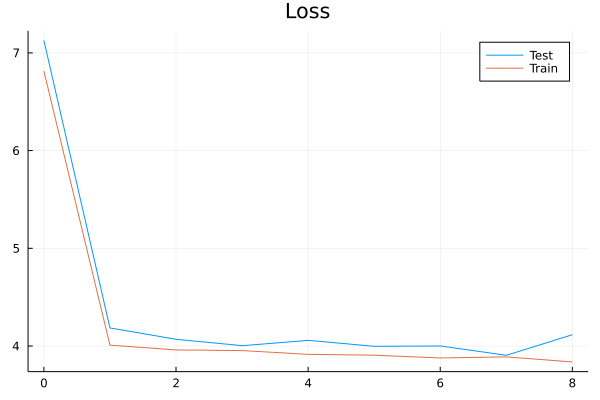

Final Results | Train Loss: 3.837055171898729 | Test Loss: 6.516157717667387


In [70]:
println("Final Results | Train Loss: $(train_losses[end]) | Test Loss: $(test_losses[end])")
loss_plot = plot(0:length(test_losses)-1, [test_losses, train_losses], labels=["Test" "Train"], title="Loss")
display(loss_plot)

### Generation

In [67]:
x = ATYPE([1,1,2,2,1,1,1])
state = nothing
composition = []
bars = 1
while true
    x, state = model(reshape(x, (1,7,1)), state=state)
    append!(composition, [reshape(x.-1, (1, 7))])
    if i2t["type"][x[4]-1] == "EOS" break; end
    if i2t["bar-beat"][x[3]-1] == "Bar" bars+=1; end
end
composition = vcat(composition...)

gen = [6, 108, 3, 2, 1, 1, 22]
x = [6, 108, 3, 2, 1, 1, 22]
gen = [1, 1, 1, 3, 68, 14, 21]
x = [1, 1, 1, 3, 68, 14, 21]
gen = [1, 1, 1, 3, 62, 12, 3]
x = [1, 1, 1, 3, 62, 12, 3]
gen = [1, 1, 1, 3, 41, 4, 19]
x = [1, 1, 1, 3, 41, 4, 19]
gen = [1, 1, 1, 3, 29, 14, 2]
x = [1, 1, 1, 3, 29, 14, 2]
gen = [17, 46, 11, 2, 1, 1, 1]
x = [17, 46, 11, 2, 1, 1, 1]
gen = [1, 1, 1, 3, 57, 18, 12]
x = [1, 1, 1, 3, 57, 18, 12]
gen = [1, 1, 1, 3, 19, 7, 15]
x = [1, 1, 1, 3, 19, 7, 15]
gen = [2, 46, 6, 2, 1, 1, 21]
x = [2, 46, 6, 2, 1, 1, 21]
gen = [1, 1, 1, 3, 58, 6, 16]
x = [1, 1, 1, 3, 58, 6, 16]
gen = [26, 7, 15, 2, 1, 1, 2]
x = [26, 7, 15, 2, 1, 1, 2]
gen = [1, 1, 1, 3, 65, 17, 17]
x = [1, 1, 1, 3, 65, 17, 17]
gen = [1, 1, 1, 3, 62, 11, 7]
x = [1, 1, 1, 3, 62, 11, 7]
gen = [1, 1, 1, 3, 54, 11, 7]
x = [1, 1, 1, 3, 54, 11, 7]
gen = [47, 1, 13, 2, 1, 1, 25]
x = [47, 1, 13, 2, 1, 1, 25]
gen = [1, 1, 1, 3, 58, 11, 20]
x = [1, 1, 1, 3, 58, 11, 20]
gen = [52, 46, 11, 2, 1, 1, 1]
x = [52, 46, 11, 2, 1, 1, 1

3400×7 Matrix{Int64}:
  5  107   2  1   0   0  21
  0    0   0  2  67  13  20
  0    0   0  2  61  11   2
  0    0   0  2  40   3  18
  0    0   0  2  28  13   1
 16   45  10  1   0   0   0
  0    0   0  2  56  17  11
  0    0   0  2  18   6  14
  1   45   5  1   0   0  20
  0    0   0  2  57   5  15
 25    6  14  1   0   0   1
  0    0   0  2  64  16  16
  0    0   0  2  61  10   6
  ⋮                   ⋮  
  1   45  10  1   0   0   7
  0    0   0  2  49  14  18
  0    0   0  2  46  12  10
  0    0   0  2  42  13   7
  1   45   8  1   0   0   7
  0    0   0  2  62  11   8
 25   45  10  1   0   0  22
  0    0   0  2  61   8  12
  1  117   1  1   0   0   0
  0    0   0  2  64   4  20
  0    0   0  2  55  16   5
  0    0   0  0   0  10   0

In [66]:
# Saving WIP

# Save as CP in NP format.
# dir = "out"
# NPZ.npzwrite("$(dir)\\cp\\comp.npz", composition)

# PyCall
# using PyCall
# pushfirst!(PyVector(pyimport("sys")."path"), "")
# write_midi = pyimport("write_midi")
# Load midi function.
# Load CP in NP format.
# Load word2event dictionary.
# Call function (composition, src, word2event)